In [1]:
%matplotlib inline

# Familiar libraries.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn import cross_validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
import time

# Take a moment to install Theano.  We will use it for building neural networks.
import theano 
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
print theano.config.device # We're using CPUs (for now)
print theano.config.floatX # Should be 64 bit for CPUs

np.random.seed(0)

gpu
float32


Using gpu device 0: GeForce GTX 960


In [79]:
# Load the kaggle training dataset
all_train_data = np.genfromtxt("training.csv", delimiter=",", skip_header=1, usecols=(30)
                           , converters={ 30: lambda x : x.replace(" ", ",") })
all_train_data = np.array(map(lambda x : np.array(x.split(",")).astype(int), all_train_data))
all_train_labels = np.genfromtxt("training.csv", delimiter=",", skip_header=1, usecols=np.arange(30))
shuffle = np.random.permutation(np.arange(len(all_train_data)))

# Split training dataset into train, dev, test
train_data, train_labels = all_train_data[shuffle[:5000]], all_train_labels[shuffle[:5000]]
dev_data, dev_labels = all_train_data[shuffle[5000:6000]], all_train_labels[shuffle[5000:6000]]
test_data, test_labels = all_train_data[shuffle[6000:]], all_train_labels[shuffle[6000:]]

# Load the kaggle test dataset
kaggle_test_data = np.genfromtxt("test.csv", delimiter=",", skip_header=1, usecols=(1), \
    converters= { 1: lambda x : x.replace(" ", ",") })
kaggle_test_data = np.array(map(lambda x : np.array(x.split(",")).astype(int), kaggle_test_data))

print train_data.shape
print train_labels.shape

(5000, 9216)
(5000, 30)


{0: 'left_eye_center_x', 1: 'left_eye_center_y', 2: 'right_eye_center_x', 3: 'right_eye_center_y', 4: 'left_eye_inner_corner_x', 5: 'left_eye_inner_corner_y', 6: 'left_eye_outer_corner_x', 7: 'left_eye_outer_corner_y', 8: 'right_eye_inner_corner_x', 9: 'right_eye_inner_corner_y', 10: 'right_eye_outer_corner_x', 11: 'right_eye_outer_corner_y', 12: 'left_eyebrow_inner_end_x', 13: 'left_eyebrow_inner_end_y', 14: 'left_eyebrow_outer_end_x', 15: 'left_eyebrow_outer_end_y', 16: 'right_eyebrow_inner_end_x', 17: 'right_eyebrow_inner_end_y', 18: 'right_eyebrow_outer_end_x', 19: 'right_eyebrow_outer_end_y', 20: 'nose_tip_x', 21: 'nose_tip_y', 22: 'mouth_left_corner_x', 23: 'mouth_left_corner_y', 24: 'mouth_right_corner_x', 25: 'mouth_right_corner_y', 26: 'mouth_center_top_lip_x', 27: 'mouth_center_top_lip_y', 28: 'mouth_center_bottom_lip_x', 29: 'mouth_center_bottom_lip_y'}


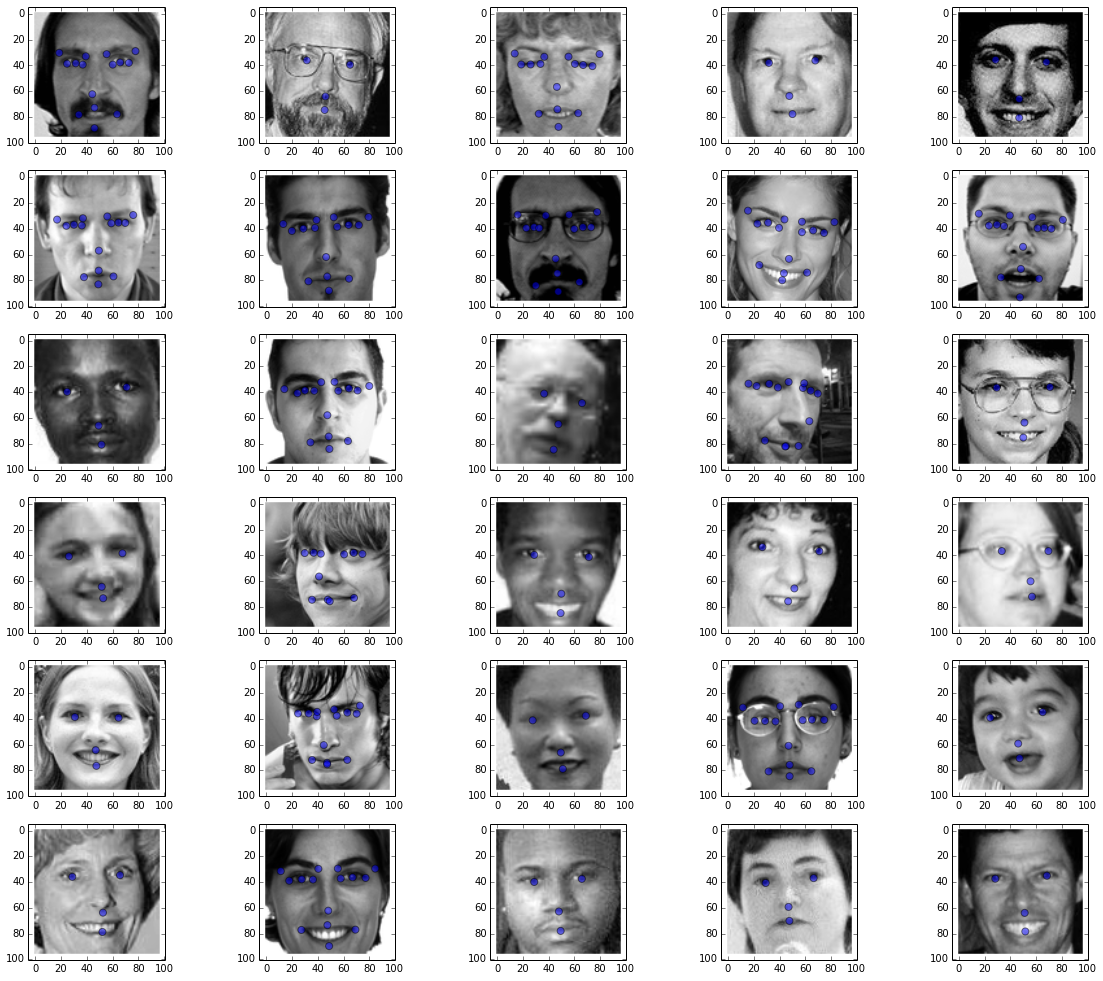

'picsplz' took 4.26 seconds


In [83]:
# Define some utility functions

# Build the feature name -> idx and idx -> feature_name mappings for easy translation
feature_dict = {}
idx_dict = {}
with open("training.csv", "r") as f:
  # Read the first entry in training.csv and split by commas
  header = f.readline().strip().split(",")[:-1]
  feature_dict = dict(enumerate(header))
  idx_dict = { v: k for k, v in feature_dict.items() }

def stopwatch(f):
  """for timing stuff"""
  def timer(*args, **kw):
    start = time.time()
    result = f(*args, **kw)
    end = time.time()
    print '%r took %.2f seconds' % (f.__name__, end-start)
    return result

  return timer

@stopwatch
def picsplz(idxs, pred_labels = [], cols = 5):
  """given a list of indices, draws the images and their facial keypoints"""
  plt.figure(figsize = (20, 20))
  for i, j in enumerate(idxs):
    ax = plt.subplot(1 + (len(idxs) / cols), cols, i+1)
    x = train_data[j].reshape((96, 96))
    ax.imshow(x, cmap = "gray")
    # TODO expand this to color dot based on type of keypoint
    ax.scatter(train_labels[j][0::2], train_labels[j][1::2], s=50, alpha=0.5)
    # if we have predicted labels, then display them as red dots
    if len(pred_labels) > j:
      ax.scatter(pred_labels[j][0::2], pred_labels[j][1::2], s=50, c="red", alpha=0.5)
  plt.show()

# Sanity check: print out our feature dictionary
print feature_dict

# Show 30 random samples
picsplz(np.random.permutation(np.arange(len(train_data)))[:30])


In [77]:
# Baseline: Linear Regression
# For each keypoint coordinate (15 * 2 = 30), train a linear regression model.
@stopwatch
def baseline(**kwargs):
  train_data = kwargs['train_data']
  train_labels = kwargs['train_labels']
  test_data = kwargs['test_data']

  print "starting training"
    
  # Train a linear regression model for each keypoint coordinate (x, y) * 15 = 30 models
  models = []
  for i in range(len(idx_dict)):
    print "- training %s model" % feature_dict[i]
    # extract the label for this feature
    feature_train_labels = train_labels[:,i]
    # remove any nan values
    remove_nan = ~np.isnan(feature_train_labels)
    feature_train_labels = feature_train_labels[remove_nan]
    feature_train_data = train_data[remove_nan]
    # train our linear regression
    feature_lr = LinearRegression()
    feature_lr.fit(feature_train_data, feature_train_labels)
    models.append(feature_lr)
    
  print "evaluating predictions"
  # Predict our test data using our models
  pred_labels = np.zeros((len(test_data), len(idx_dict)))
  for i in range(len(test_data)):
    pred_labels[i,:] = [ m.predict(test_data[i]) for m in models ]

  return (models, pred_labels)

def rmse(pred_labels, actual_labels):
  """compute rmse"""
  cleaned = np.copy(actual_labels)
  # set all missing features to 0 when doing rmse computation
  # this is debatable
  np.place(actual_labels, np.isnan(actual_labels), 0.0)
  return np.sqrt(mean_squared_error(actual_labels, pred_labels))

RMSE: 36.3464


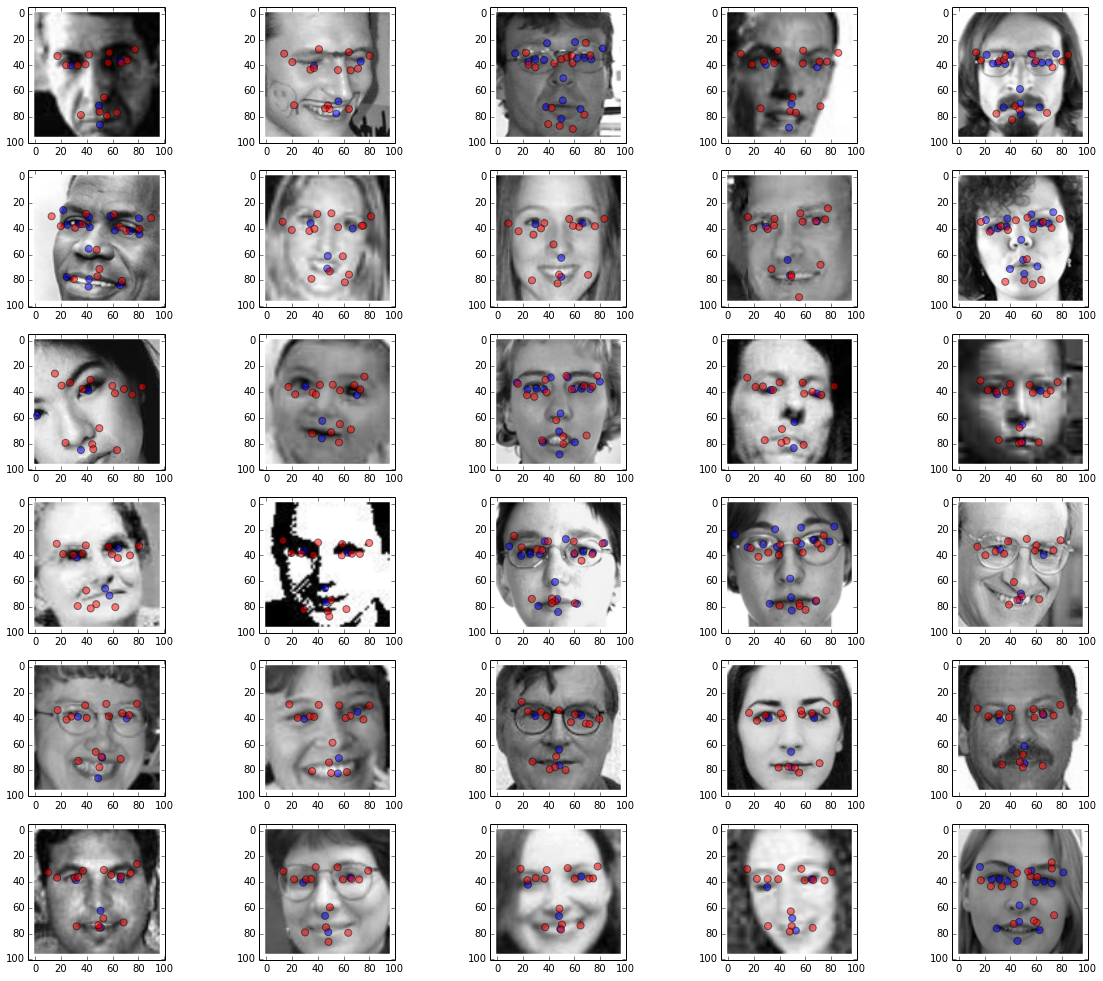

In [36]:
# Try running our baseline against our own test set
models, pred_labels = baseline(train_data = train_data, train_labels = train_labels, test_data = dev_data)

print "RMSE: %2.4f" % rmse(labels, dev_labels)

# Visualize how well our model is doing against truth
picsplz(np.random.permutation(np.arange(len(train_data[:1000])))[:30], labels)

In [3]:
@stopwatch
def kaggleize(output, labels):
  """given a set of labels for the test set, output our results in the expected kaggle format"""

  assert len(labels) == 1783, "Expecting 1783 labels, found %d" % len(labels)

  with open("IdLookupTable.csv", "r") as f_in, open(output, "w") as f_out:
    # Skip first line, since it's the header
    f_in.readline()

    f_out.write("RowId,Location\n")
    for line in f_in:
      entry = line.strip().split(",")
      row = int(entry[0])
      idx = int(entry[1])
      feature = entry[2]
      location = round(labels[idx-1, idx_dict[feature]])
      # max value is 96 and min value is 0
      bounded_location = max(0, min(96, location))
      f_out.write("%d,%d\n" % (row, bounded_location))

NameError: name 'stopwatch' is not defined

In [ ]:
# Evaluate our baseline against the entire training set and generate sample set
# Train our baseline
models, pred_labels = baseline(train_data = all_train_data, train_labels = all_train_labels, test_data = kaggle_test_data)

# Output our baseline results to kaggle format
kaggleize("output.csv", pred_labels)

# Profit!
print "done!"